Madusanka Madiligama 01/10/2024

In [90]:
# Library imports
import io
import os
import gc
import requests
import zipfile
import datetime

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Configure plot aesthetics for matplotlib and seaborn.
def set_plot_aesthetics():

    plt.rcParams['figure.figsize'] = (10, 8)  
    plt.rcParams['xtick.labelsize'] = 13      
    plt.rcParams['ytick.labelsize'] = 13      
    plt.rcParams['axes.labelsize'] = 14       
    sns.set_palette('tab10')                  

# Apply the plot settings
set_plot_aesthetics()
colors = list(sns.color_palette('tab10')) 

In [3]:
# read the CSV file for the air quality data from Dingling station
base_dir = '../Data/PRSA_Data_20130301-20170228'
file_name = 'PRSA_Data_Dingling_20130301-20170228.csv'
df = pd.read_csv(os.path.join(base_dir, file_name), encoding='ISO-8859-1')
df.head()

No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0  3.0  NaN  200.0  82.0  -2.3   
1   2  2013      3    1     1    7.0   7.0  3.0  NaN  200.0  80.0  -2.5   
2   3  2013      3    1     2    5.0   5.0  3.0  2.0  200.0  79.0  -3.0   
3   4  2013      3    1     3    6.0   6.0  3.0  NaN  200.0  79.0  -3.6   
4   5  2013      3    1     4    5.0   5.0  3.0  NaN  200.0  81.0  -3.5   

     PRES  DEWP  RAIN   wd  WSPM   station  
0  1020.8 -19.7   0.0    E   0.5  Dingling  
1  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2  1021.3 -19.9   0.0  ENE   0.2  Dingling  
3  1021.8 -19.1   0.0  NNE   1.0  Dingling  
4  1022.3 -19.4   0.0    N   2.1  Dingling

In [4]:
# quick look at the data
df.info()
     

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       35064 non-null  int64  
 1   year     35064 non-null  int64  
 2   month    35064 non-null  int64  
 3   day      35064 non-null  int64  
 4   hour     35064 non-null  int64  
 5   PM2.5    34285 non-null  float64
 6   PM10     34408 non-null  float64
 7   SO2      34334 non-null  float64
 8   NO2      33830 non-null  float64
 9   CO       33052 non-null  float64
 10  O3       33850 non-null  float64
 11  TEMP     35011 non-null  float64
 12  PRES     35014 non-null  float64
 13  DEWP     35011 non-null  float64
 14  RAIN     35013 non-null  float64
 15  wd       34924 non-null  object 
 16  WSPM     35021 non-null  float64
 17  station  35064 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [5]:
#convert date into datetime
def convert_to_date(x):
    return datetime.datetime.strptime(x, '%m/%d/%Y')

In [6]:
def combine_and_convert_to_datetime(df):
    # Combine the year, month, day, and hour columns into a single string column
    df['datetime'] = df['year'].astype(str) + " " + df['month'].astype(str) + " " + \
                     df['day'].astype(str) + " " + df['hour'].astype(str)

    # Convert the combined string to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y %m %d %H')

    return df


# Apply the function
df = combine_and_convert_to_datetime(df)
df.head(5)

No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0  3.0  NaN  200.0  82.0  -2.3   
1   2  2013      3    1     1    7.0   7.0  3.0  NaN  200.0  80.0  -2.5   
2   3  2013      3    1     2    5.0   5.0  3.0  2.0  200.0  79.0  -3.0   
3   4  2013      3    1     3    6.0   6.0  3.0  NaN  200.0  79.0  -3.6   
4   5  2013      3    1     4    5.0   5.0  3.0  NaN  200.0  81.0  -3.5   

     PRES  DEWP  RAIN   wd  WSPM   station            datetime  
0  1020.8 -19.7   0.0    E   0.5  Dingling 2013-03-01 00:00:00  
1  1021.3 -19.0   0.0  ENE   0.7  Dingling 2013-03-01 01:00:00  
2  1021.3 -19.9   0.0  ENE   0.2  Dingling 2013-03-01 02:00:00  
3  1021.8 -19.1   0.0  NNE   1.0  Dingling 2013-03-01 03:00:00  
4  1022.3 -19.4   0.0    N   2.1  Dingling 2013-03-01 04:00:00

In [7]:
df.month = df['month'].astype(int)

In [8]:
#Calculate the number and percentage of missing values in each column of a DataFrame.

def missing_values(df):

    # Calculate the number of missing values per column
    missing_count = df.isnull().sum()

    # Calculate the percentage of missing values
    missing_percent = np.round((100 * missing_count) / len(df), 2)

    # Create a DataFrame to display the results
    missing_data = pd.DataFrame({
        '# Missing': missing_count, 
        '% Missing': missing_percent
    })

    return missing_data


#Prints basic information about the DataFrame, including its size, features, missing values, and unique values count.
def print_data_info(df):

    print(f"Rows: {df.shape[0]}")
    print(f"Columns: {df.shape[1]}")
    print("\nFeatures:")
    print("-" * 10)
    print(df.columns.tolist())
    
    print("\nMissing Values:")
    print("-" * 15)
    print(missing_values(df))
    
    print("\nUnique Values Count:")
    print("-" * 15)
    print(df.nunique())

# printing basic info about the data
print_data_info(df)

Rows: 35064
Columns: 19

Features:
----------
['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime']

Missing Values:
---------------
          # Missing  % Missing
No                0       0.00
year              0       0.00
month             0       0.00
day               0       0.00
hour              0       0.00
PM2.5           779       2.22
PM10            656       1.87
SO2             730       2.08
NO2            1234       3.52
CO             2012       5.74
O3             1214       3.46
TEMP             53       0.15
PRES             50       0.14
DEWP             53       0.15
RAIN             51       0.15
wd              140       0.40
WSPM             43       0.12
station           0       0.00
datetime          0       0.00

Unique Values Count:
---------------
No          35064
year            5
month          12
day            31
hour           24
PM2.5         486
PM10

In [9]:
# printing the summary statistics
df.describe()

No          year         month           day          hour  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean   17532.500000   2014.662560      6.522930     15.729637     11.500000   
min        1.000000   2013.000000      1.000000      1.000000      0.000000   
25%     8766.750000   2014.000000      4.000000      8.000000      5.750000   
50%    17532.500000   2015.000000      7.000000     16.000000     11.500000   
75%    26298.250000   2016.000000     10.000000     23.000000     17.250000   
max    35064.000000   2017.000000     12.000000     31.000000     23.000000   
std    10122.249256      1.177213      3.448752      8.800218      6.922285   

              PM2.5          PM10           SO2           NO2            CO  \
count  34285.000000  34408.000000  34334.000000  33830.000000  33052.000000   
mean      65.989497     83.739723     11.749650     27.585467    904.896073   
min        3.000000      2.000000      0.285600      1.026500    100.000000   
25%       14.000000     26.000000      2.000000      9.000000    300.000000   
50%       41.000000     60.000000      5.000000     19.000000    600.000000   
75%       93.000000    117.000000     15.000000     38.000000   1200.000000   
max      881.000000    905.000000    156.000000    205.000000  10000.000000   
std       72.267723     79.541685     15.519259     26.383882    903.306220   

                 O3          TEMP          PRES          DEWP          RAIN  \
count  33850.000000  35011.000000  35014.000000  35011.000000  35013.000000   
mean      68.548371     13.686111   1007.760278      1.505495      0.060366   
min        0.214200    -16.600000    982.400000    -35.100000      0.000000   
25%       31.000000      3.400000    999.300000    -10.200000      0.000000   
50%       61.000000     14.700000   1007.400000      1.800000      0.000000   
75%       90.000000     23.300000   1016.000000     14.200000      0.000000   
max      500.000000     41.400000   1036.500000     27.200000     52.100000   
std       53.764424     11.365313     10.225664     13.822099      0.752899   

               WSPM             datetime  
count  35021.000000                35064  
mean       1.853836  2015-03-01 11:30:00  
min        0.000000  2013-03-01 00:00:00  
25%        1.000000  2014-03-01 05:45:00  
50%        1.500000  2015-03-01 11:30:00  
75%        2.300000  2016-02-29 17:15:00  
max       10.000000  2017-02-28 23:00:00  
std        1.309808                  NaN

In [10]:

# creating a copy of dataframe without timestamp as index
df_non_indexed = df.copy()

In [11]:
# Incredibly useful technique for time series data; check the advantages in below cells
df.set_index('datetime', inplace=True)
df.head()

No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO  \
datetime                                                                        
2013-03-01 00:00:00   1  2013      3    1     0    4.0   4.0  3.0  NaN  200.0   
2013-03-01 01:00:00   2  2013      3    1     1    7.0   7.0  3.0  NaN  200.0   
2013-03-01 02:00:00   3  2013      3    1     2    5.0   5.0  3.0  2.0  200.0   
2013-03-01 03:00:00   4  2013      3    1     3    6.0   6.0  3.0  NaN  200.0   
2013-03-01 04:00:00   5  2013      3    1     4    5.0   5.0  3.0  NaN  200.0   

                       O3  TEMP    PRES  DEWP  RAIN   wd  WSPM   station  
datetime                                                                  
2013-03-01 00:00:00  82.0  -2.3  1020.8 -19.7   0.0    E   0.5  Dingling  
2013-03-01 01:00:00  80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2013-03-01 02:00:00  79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2  Dingling  
2013-03-01 03:00:00  79.0  -3.6  1021.8 -19.1   0.0  NNE   1.0  Dingling  
2013-03-01 04:00:00  81.0  -3.5  1022.3 -19.4   0.0    N   2.1  Dingling

In [12]:
# Once indexed, can be easily sliced using loc, iloc
df.loc['2013-03-01':'2013-03-05']

No  year  month  day  hour  PM2.5   PM10   SO2   NO2  \
datetime                                                                     
2013-03-01 00:00:00    1  2013      3    1     0    4.0    4.0   3.0   NaN   
2013-03-01 01:00:00    2  2013      3    1     1    7.0    7.0   3.0   NaN   
2013-03-01 02:00:00    3  2013      3    1     2    5.0    5.0   3.0   2.0   
2013-03-01 03:00:00    4  2013      3    1     3    6.0    6.0   3.0   NaN   
2013-03-01 04:00:00    5  2013      3    1     4    5.0    5.0   3.0   NaN   
...                  ...   ...    ...  ...   ...    ...    ...   ...   ...   
2013-03-05 19:00:00  116  2013      3    5    19  179.0  200.0  50.0  96.0   
2013-03-05 20:00:00  117  2013      3    5    20  172.0  180.0  43.0  94.0   
2013-03-05 21:00:00  118  2013      3    5    21  179.0  191.0  38.0  80.0   
2013-03-05 22:00:00  119  2013      3    5    22  173.0  168.0  39.0  73.0   
2013-03-05 23:00:00  120  2013      3    5    23  170.0  162.0  42.0  72.0   

                         CO    O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  \
datetime                                                                 
2013-03-01 00:00:00   200.0  82.0  -2.3  1020.8 -19.7   0.0    E   0.5   
2013-03-01 01:00:00   200.0  80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7   
2013-03-01 02:00:00   200.0  79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2   
2013-03-01 03:00:00   200.0  79.0  -3.6  1021.8 -19.1   0.0  NNE   1.0   
2013-03-01 04:00:00   200.0  81.0  -3.5  1022.3 -19.4   0.0    N   2.1   
...                     ...   ...   ...     ...   ...   ...  ...   ...   
2013-03-05 19:00:00  1600.0  82.0   7.7  1005.4  -7.6   0.0  NNE   0.2   
2013-03-05 20:00:00  1899.0  82.0   6.3  1005.9  -7.3   0.0  NNE   0.7   
2013-03-05 21:00:00  1700.0  82.0   5.6  1006.0  -7.3   0.0  NNE   0.2   
2013-03-05 22:00:00  1800.0  82.0   4.9  1005.8  -7.0   0.0    N   1.7   
2013-03-05 23:00:00  1700.0  82.0   3.7  1005.7  -6.9   0.0   NE   0.4   

                      station  
datetime                       
2013-03-01 00:00:00  Dingling  
2013-03-01 01:00:00  Dingling  
2013-03-01 02:00:00  Dingling  
2013-03-01 03:00:00  Dingling  
2013-03-01 04:00:00  Dingling  
...                       ...  
2013-03-05 19:00:00  Dingling  
2013-03-05 20:00:00  Dingling  
2013-03-05 21:00:00  Dingling  
2013-03-05 22:00:00  Dingling  
2013-03-05 23:00:00  Dingling  

[120 rows x 18 columns]

In [13]:
df.loc['2013':'2015']

No  year  month  day  hour  PM2.5   PM10   SO2   NO2  \
datetime                                                                       
2013-03-01 00:00:00      1  2013      3    1     0    4.0    4.0   3.0   NaN   
2013-03-01 01:00:00      2  2013      3    1     1    7.0    7.0   3.0   NaN   
2013-03-01 02:00:00      3  2013      3    1     2    5.0    5.0   3.0   2.0   
2013-03-01 03:00:00      4  2013      3    1     3    6.0    6.0   3.0   NaN   
2013-03-01 04:00:00      5  2013      3    1     4    5.0    5.0   3.0   NaN   
...                    ...   ...    ...  ...   ...    ...    ...   ...   ...   
2015-12-31 19:00:00  24860  2015     12   31    19   85.0   95.0  12.0  73.0   
2015-12-31 20:00:00  24861  2015     12   31    20    NaN  109.0  32.0  79.0   
2015-12-31 21:00:00  24862  2015     12   31    21   80.0  100.0  35.0  81.0   
2015-12-31 22:00:00  24863  2015     12   31    22   93.0   93.0  28.0  76.0   
2015-12-31 23:00:00  24864  2015     12   31    23   98.0   98.0  25.0  75.0   

                         CO    O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  \
datetime                                                                 
2013-03-01 00:00:00   200.0  82.0  -2.3  1020.8 -19.7   0.0    E   0.5   
2013-03-01 01:00:00   200.0  80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7   
2013-03-01 02:00:00   200.0  79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2   
2013-03-01 03:00:00   200.0  79.0  -3.6  1021.8 -19.1   0.0  NNE   1.0   
2013-03-01 04:00:00   200.0  81.0  -3.5  1022.3 -19.4   0.0    N   2.1   
...                     ...   ...   ...     ...   ...   ...  ...   ...   
2015-12-31 19:00:00  1200.0   2.0  -0.6  1021.0  -9.5   0.0   NE   0.6   
2015-12-31 20:00:00  2900.0   2.0  -1.8  1021.2  -9.9   0.0   NW   1.1   
2015-12-31 21:00:00  3200.0   2.0  -1.6  1020.8  -9.7   0.0   NE   0.9   
2015-12-31 22:00:00  3500.0   2.0  -2.9  1020.4  -9.8   0.0  NNW   1.3   
2015-12-31 23:00:00  3600.0   2.0  -3.5  1020.2  -9.7   0.0  NNW   1.3   

                      station  
datetime                       
2013-03-01 00:00:00  Dingling  
2013-03-01 01:00:00  Dingling  
2013-03-01 02:00:00  Dingling  
2013-03-01 03:00:00  Dingling  
2013-03-01 04:00:00  Dingling  
...                       ...  
2015-12-31 19:00:00  Dingling  
2015-12-31 20:00:00  Dingling  
2015-12-31 21:00:00  Dingling  
2015-12-31 22:00:00  Dingling  
2015-12-31 23:00:00  Dingling  

[24864 rows x 18 columns]

In [14]:
pm_data = df['PM2.5']
pm_data.head()

datetime
2013-03-01 00:00:00    4.0
2013-03-01 01:00:00    7.0
2013-03-01 02:00:00    5.0
2013-03-01 03:00:00    6.0
2013-03-01 04:00:00    5.0
Name: PM2.5, dtype: float64

Particulate matter (PM) is a significant factor in air quality degradation, with PM2.5 being a primary contributor to particle pollution. PM2.5 consists of fine inhalable particles with diameters at or below 2.5 micrometers, which are small enough to penetrate deep into the respiratory system. In this dataset, we will investigate the conditions and various factors that contribute to elevated levels of PM2.5 in the atmosphere.

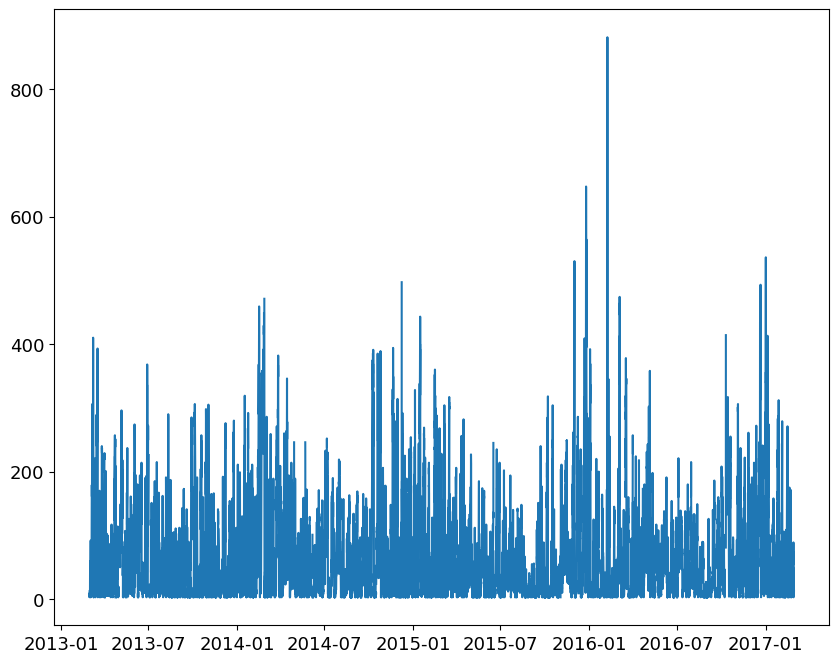

In [15]:
# checking out the distribution of particulate matter `PM2.5` in 4 years
plt.plot(pm_data, color=colors[0])
plt.show()

The overall dataset presents a challenge in discerning clear patterns due to data cluttering. To gain better insights, we will focus on analyzing the distribution of Particulate Matter (PM2.5) across different years. This approach should help in identifying any trends or changes in PM2.5 levels on a yearly basis.

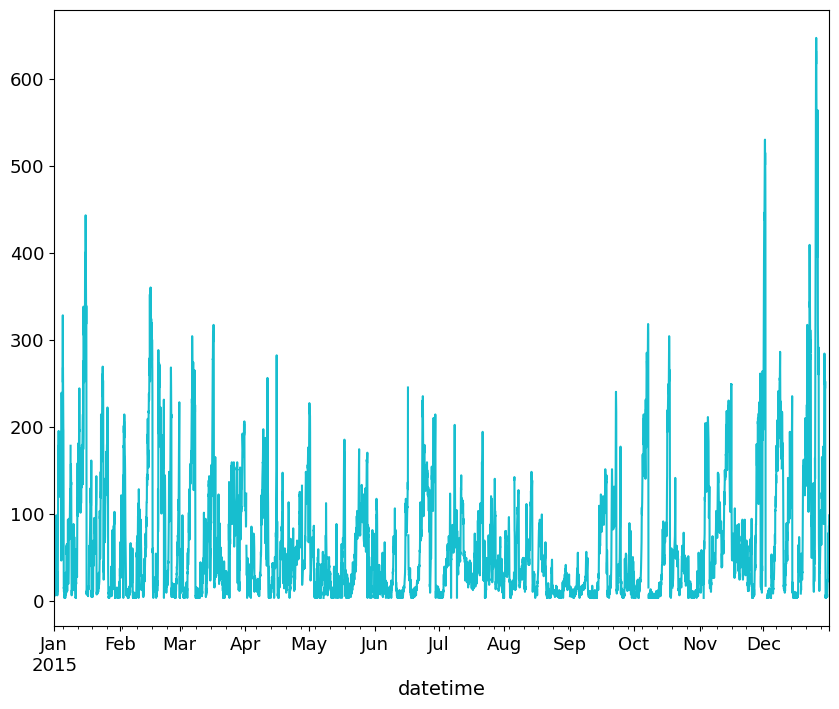

In [16]:
# filter out the data for 2015
df_2015 = df.loc['2015']
pm_data_2015 = df_2015['PM2.5']
pm_data_2015.plot(color=colors[9])
plt.show()

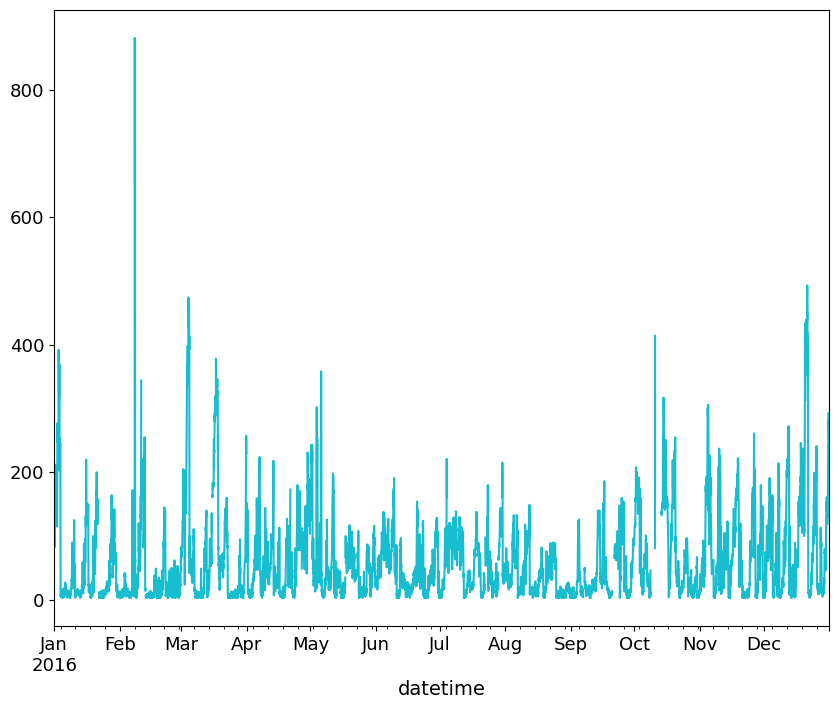

In [17]:
# filter out the data for 2016
df_2016 = df.loc['2016']
pm_data_2016 = df_2016['PM2.5']
pm_data_2016.plot(color=colors[9])
plt.show()

The data reveals that during the winter months, particularly from November to March, the concentration of particulate matter (PM2.5) is significantly higher in both 2015 and 2016. In contrast, there is a noticeable decrease in these levels during the summer months. Further analysis will be conducted to explore the potential correlation between particulate matter concentrations and temperature variations.

To facilitate a more comprehensive and user-friendly analysis of the entire dataset, we will employ interactive plotting techniques using Plotly. This approach not only enhances data visualization but also provides the convenience of filtering the data across different time ranges with ease

In [18]:

fig = go.Figure()

# Create a Scatter plot trace for the PM2.5 data
trace = go.Scatter(
    x=df_non_indexed['datetime'],
    y=df_non_indexed['PM2.5'],
    mode='lines+markers',  
    marker=dict(color='blue' ,size= 1),
    name='PM2.5'  
)
fig.add_trace(trace)

# Define the layout with improved settings
layout = dict(
    title=dict(
        text='PM2.5 Concentration Over Time',
        x=0.5,  # Center the title
        font=dict(size=18)  # Adjust font size
    ),
    xaxis=dict(
        title='Date',
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1Y', step='year', stepmode='backward'),
                dict(count=2, label='2Y', step='year', stepmode='backward'),
                dict(count=3, label='3Y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis=dict(
        title='PM2.5 Level'
    )
)

fig.update_layout(layout)

# Show the plot
fig.show()


c:\Users\nikmb\.conda\envs\ts\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



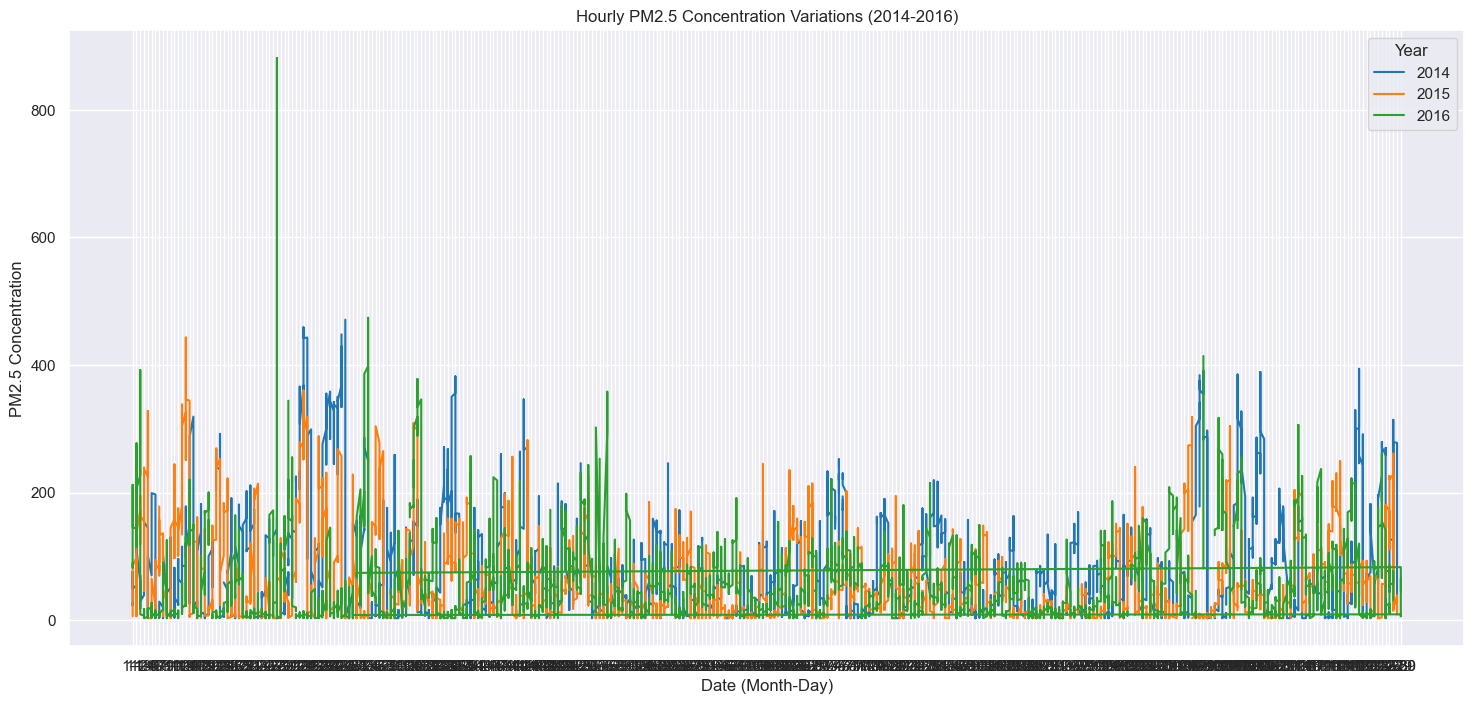

In [19]:

sns.set(style="darkgrid")

# Set figure size
plt.figure(figsize=(18, 8))

# Prepare data for years 2014, 2015, and 2016
df_2014 = df.loc['2014'].reset_index()
df_2015 = df.loc['2015'].reset_index()
df_2016 = df.loc['2016'].reset_index()

# Create 'month_day' column for each year's DataFrame
df_2014['month_day'] = df_2014['month'].astype(str) + '-' + df_2014['day'].astype(str)
df_2015['month_day'] = df_2015['month'].astype(str) + '-' + df_2015['day'].astype(str)
df_2016['month_day'] = df_2016['month'].astype(str) + '-' + df_2016['day'].astype(str)

# Plot for each year
plt.plot('month_day', 'PM2.5', data=df_2014[:8000], color=colors[0], label='2014')
plt.plot('month_day', 'PM2.5', data=df_2015[:8000], color=colors[1], label='2015')
plt.plot('month_day', 'PM2.5', data=df_2016[:8000], color=colors[2], label='2016')

# Set labels, title, and legend
plt.xlabel('Date (Month-Day)')
plt.ylabel('PM2.5 Concentration')
plt.title('Hourly PM2.5 Concentration Variations (2014-2016)')
plt.legend(title='Year')


#plt.xticks(rotation=45)
plt.show()


The provided plot illustrates the hourly fluctuations in PM2.5 concentrations throughout each hour of the year from 2014 to 2016. The data aligns with expected seasonal trends: higher concentrations in winter and lower levels in summer.

To gain further insights, examining the monthly average PM2.5 concentrations for each year would be beneficial. This approach could reveal more nuanced patterns and variations not immediately apparent in the hourly data.

In [35]:
pm_data_monthly_avg = df.pivot_table(values=['PM2.5'], index=['month'], columns=['year'])
pm_data_monthly_avg.columns = pm_data_monthly_avg.columns.droplevel(level=0)
pm_data_monthly_avg.drop([2013, 2017], axis=1, inplace=True)
pm_data_monthly_avg

year         2014        2015       2016
month                                   
1       71.245492   85.761507  53.678670
2      148.838710   81.007440  35.220117
3       83.395693   74.795122  82.389877
4       87.515850   56.239155  60.480742
5       47.420572   46.080054  50.549512
6       39.896199   50.572943  49.182451
7       78.745330   49.486559  57.081855
8       51.873333   35.029851  37.202997
9       54.214530   38.206215  43.614458
10     117.084815   53.299590  76.431341
11      71.507392   85.311174  75.790795
12      47.123288  121.651389  95.596467

In [42]:
# Check the column names and their types
print(pm_data_monthly_avg.columns)
print(pm_data_monthly_avg.dtypes)


Index([2014, 2015, 2016], dtype='int64', name='year')
year
2014    float64
2015    float64
2016    float64
dtype: object


In [47]:
#plot Monthly Average PM2.5 Concentrations (2014-2016)

months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

trace1 = go.Scatter(
    x=months, y=pm_data_monthly_avg[2014], 
    mode='lines+markers', name='2014'
)
trace2 = go.Scatter(
    x=months, y=pm_data_monthly_avg[2015], 
    mode='lines+markers', name='2015'
)
trace3 = go.Scatter(
    x=months, y=pm_data_monthly_avg[2016], 
    mode='lines+markers', name='2016'
)

data = [trace1, trace2, trace3]

layout = dict(
    title='Monthly Average PM2.5 Concentrations (2014-2016)',
    xaxis=dict(title='Month'),
    yaxis=dict(title='PM2.5 Concentration (µg/m³)'),
    plot_bgcolor='rgba(223, 232, 243, 0.2)',
    height=600, width=800,
    hovermode='closest'
)

fig = go.Figure(data=data, layout=layout)
fig.show()


The observed plot aligns with the initial hypothesis that particulate matter concentrations are higher in the winter months. To further our understanding, it would be insightful to examine the monthly averages of particulate matter aggregated across all years.

In [48]:
#  evaluate the annual aggregate data, accompanied by key summary statistics for comprehensive analysis.
df['2014':'2016'][['month', 'PM2.5']].groupby('month').describe()

PM2.5                                                       
        count       mean         std  min   25%   50%     75%    max
month                                                               
1      2173.0  70.285274   75.913587  3.0  12.0  38.0  113.00  443.0
2      1978.0  86.389282  105.603069  3.0  10.0  33.0  132.00  881.0
3      2212.0  80.193852   87.889440  3.0  13.0  47.0  123.25  474.0
4      2105.0  67.963325   56.430235  3.0  25.0  54.0   95.00  346.0
5      2188.0  47.994378   44.843130  3.0  16.0  35.0   67.00  358.0
6      2119.0  46.655403   43.877349  3.0  13.0  31.0   69.00  245.0
7      2205.0  61.671474   50.926149  3.0  21.0  48.0   91.00  252.0
8      2206.0  41.364869   37.279312  3.0  13.0  29.0   60.00  217.0
9      2074.0  45.356123   43.235331  3.0  11.0  27.0   78.00  240.0
10     2081.0  82.586257   92.234361  3.0  13.0  43.0  124.00  414.0
11     2141.0  77.500140   71.720648  3.0  20.0  56.0  112.00  394.0
12     2186.0  87.990851  104.677021  3.0  11.0  48.5  135.00  647.0

The following step involves investigating the potential correlation between temperature and particulate matter levels.

In [49]:
df['2014':'2016'][['month', 'PM2.5', 'TEMP']].groupby('month').agg({'PM2.5':['max'], 'TEMP':['min', 'max']})

PM2.5  TEMP      
         max   min   max
month                   
1      443.0 -16.6  12.4
2      881.0 -10.9  14.0
3      474.0  -6.4  26.0
4      346.0   1.3  32.0
5      358.0   7.0  41.4
6      245.0  15.1  38.1
7      252.0  16.8  39.2
8      217.0  16.6  36.3
9      240.0   7.8  34.5
10     414.0  -1.4  28.1
11     394.0 -10.3  20.8
12     647.0  -9.7  11.6

In [52]:
df.head()

No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO  \
datetime                                                                        
2013-03-01 00:00:00   1  2013      3    1     0    4.0   4.0  3.0  NaN  200.0   
2013-03-01 01:00:00   2  2013      3    1     1    7.0   7.0  3.0  NaN  200.0   
2013-03-01 02:00:00   3  2013      3    1     2    5.0   5.0  3.0  2.0  200.0   
2013-03-01 03:00:00   4  2013      3    1     3    6.0   6.0  3.0  NaN  200.0   
2013-03-01 04:00:00   5  2013      3    1     4    5.0   5.0  3.0  NaN  200.0   

                       O3  TEMP    PRES  DEWP  RAIN   wd  WSPM   station  
datetime                                                                  
2013-03-01 00:00:00  82.0  -2.3  1020.8 -19.7   0.0    E   0.5  Dingling  
2013-03-01 01:00:00  80.0  -2.5  1021.3 -19.0   0.0  ENE   0.7  Dingling  
2013-03-01 02:00:00  79.0  -3.0  1021.3 -19.9   0.0  ENE   0.2  Dingling  
2013-03-01 03:00:00  79.0  -3.6  1021.8 -19.1   0.0  NNE   1.0  Dingling  
2013-03-01 04:00:00  81.0  -3.5  1022.3 -19.4   0.0    N   2.1  Dingling

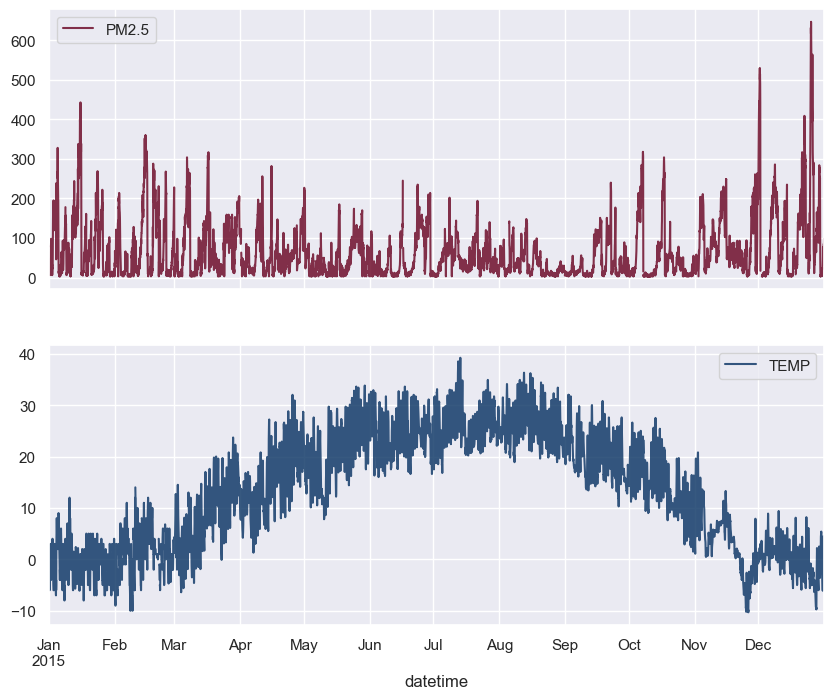

In [58]:
#Plot PM2.5 and TEMP for 2015
pm_data_2015 = df[df['year']==2015][['PM2.5', 'TEMP']]
pm_data_2015.plot(subplots=True, colormap=plt.cm.RdBu, alpha=0.8)
plt.show()

The plot distinctly illustrates a negative correlation between PM2.5 levels and temperature.

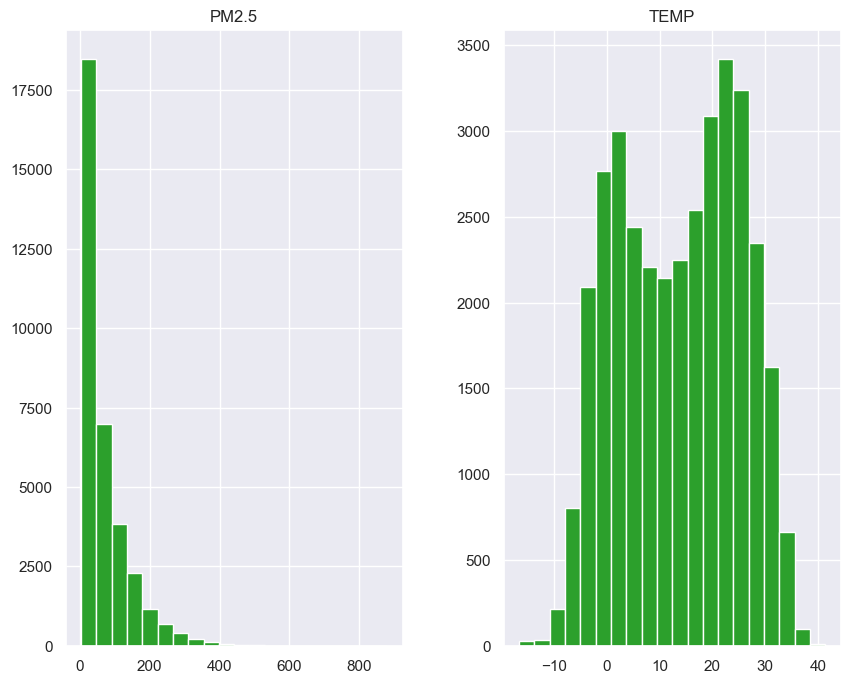

In [59]:
# checking the distribution of PM2.5 and temperature in the data
df[['PM2.5', 'TEMP']].hist(color=colors[2], bins=20);

The PM2.5 distribution appears to be right-skewed, with a few potential outliers, while the temperature distribution exhibits a bimodal characteristic.

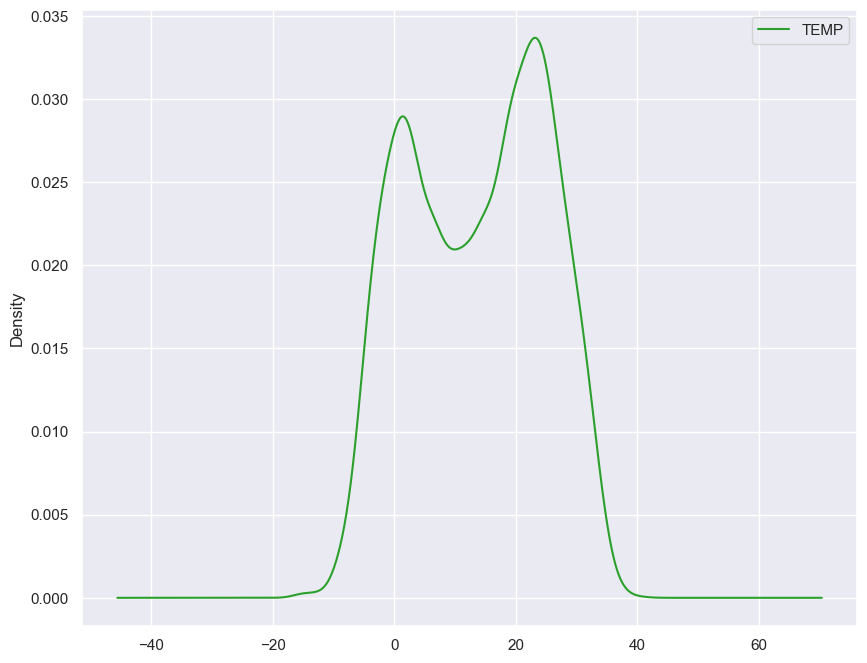

In [60]:
df[['TEMP']].plot(kind='density', color=colors[2]);

Moving forward, our analysis will focus on examining the autocorrelation among different features. Utilizing the pandas lag_plot function, we can construct autocorrelation plots. Given that the smallest time unit in our air quality dataset is one hour (as data is recorded hourly), it would be insightful to plot autocorrelations at various intervals: 1 hour, 10 hours, 24 hours (1 day), 3 months (1 quarter), 6 months (half a year), and 1 year.

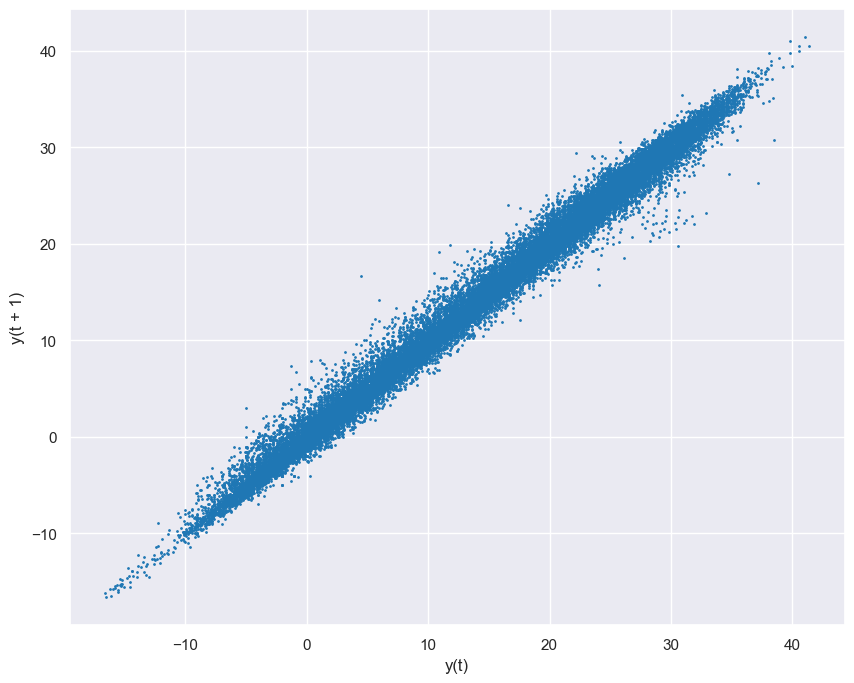

In [67]:
pd.plotting.lag_plot(df['TEMP'], lag=1, s=1,c=[colors[0]]);

As anticipated, with a one-hour lag, the temperature (TEMP) shows minimal variation. This is evident from the strong correlation observed between y(t) and y(t+1).

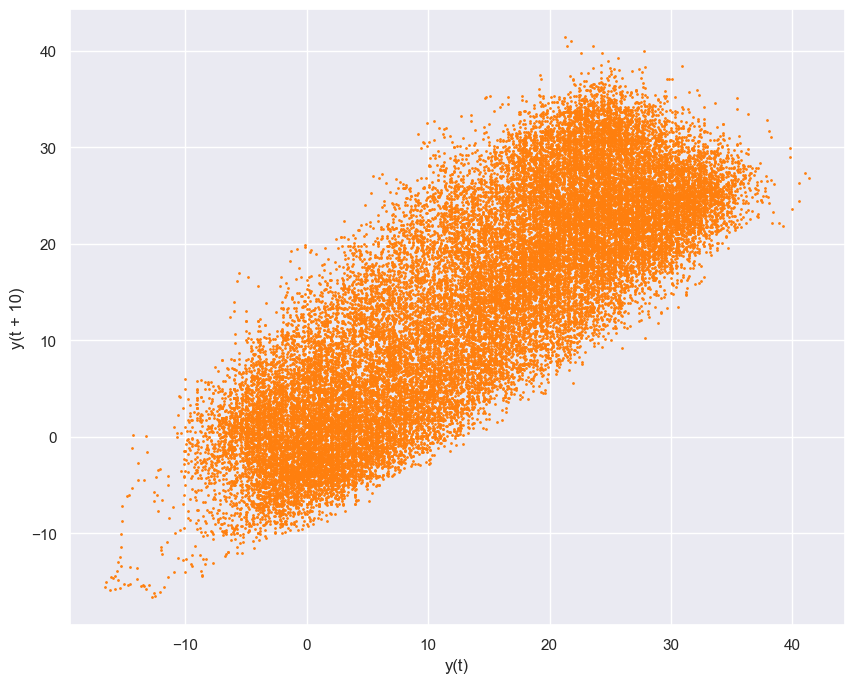

In [72]:

pd.plotting.lag_plot(df['TEMP'], lag=10,s=1, c=[colors[1]]);

With a 10-hour lag, there's noticeably more dispersion and a reduced correlation in the temperature data. This is logical, as temperature can vary substantially within 10 hours, particularly with the transition from day to night and vice versa.

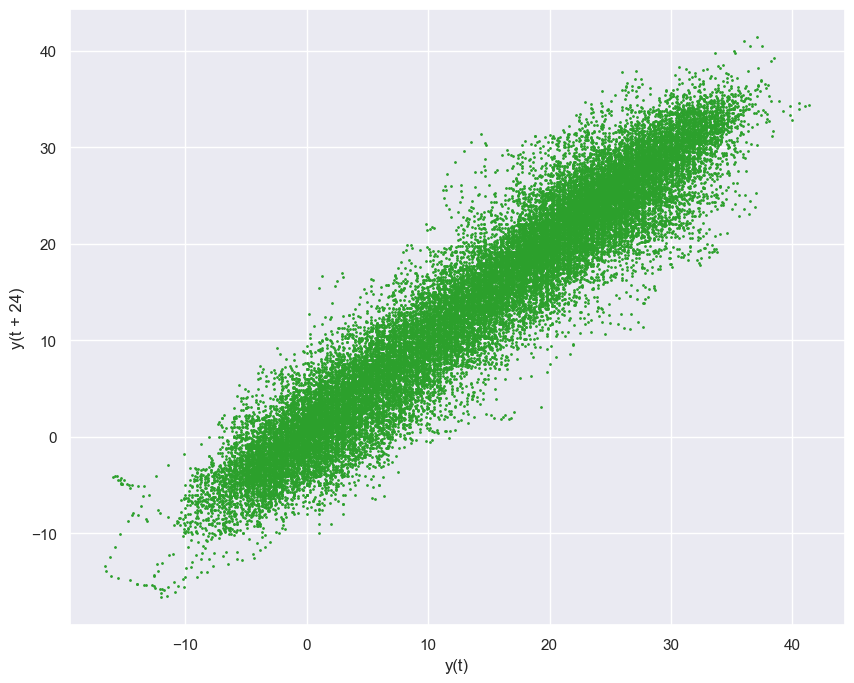

In [73]:
pd.plotting.lag_plot(df['TEMP'], lag=24,s=1, c=[colors[2]]);

A lag of one day (24 hours) demonstrates a much stronger correlation compared to a 10-hour lag. This is likely due to the weather patterns being nearly identical after a 24-hour cycle.

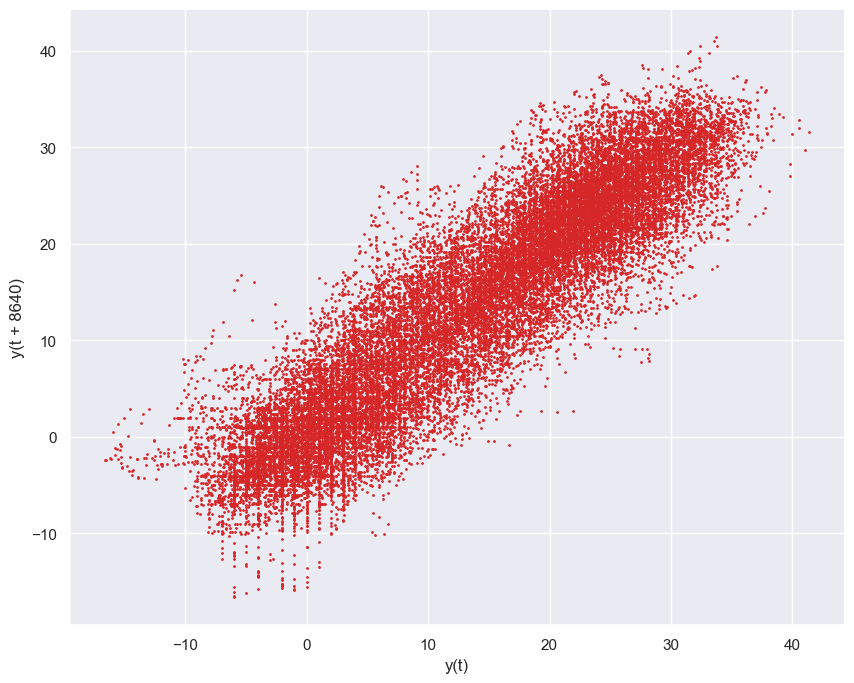

In [75]:
pd.plotting.lag_plot(df['TEMP'], lag=8640,s=1, c=[colors[3]]);

Similar to the one-day lag, a one-year lag exhibits a stronger correlation compared to a 10-hour lag, which can be attributed to the repetitive and periodic nature of weather patterns over a yearly cycle.

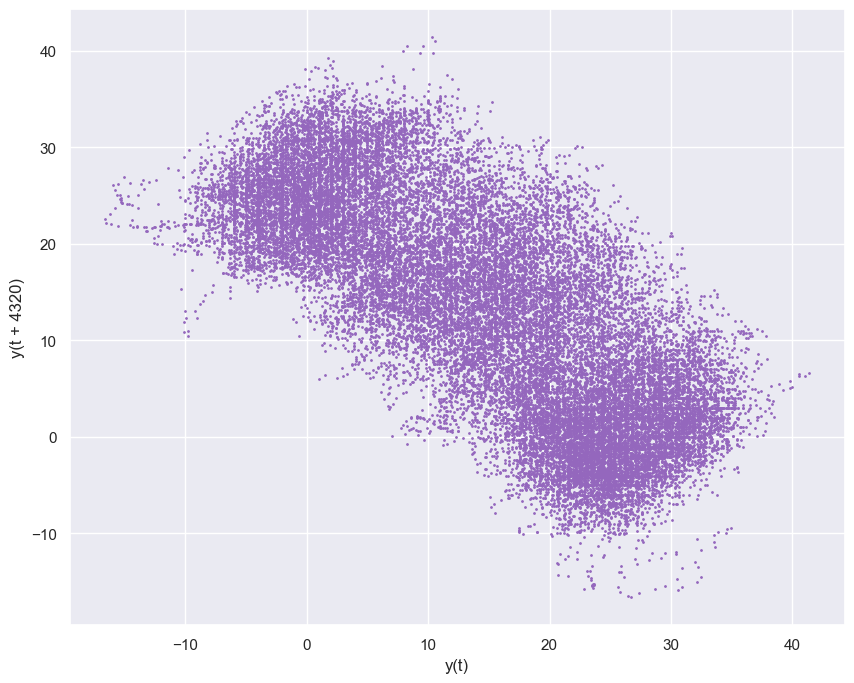

In [77]:
pd.plotting.lag_plot(df['TEMP'], lag=4320,s=1, c=[colors[4]]);

The plot becomes particularly intriguing with a six-month lag. It reveals a negative correlation between y(t) and y(t+4320). This likely stems from the seasonal transition, where summer shifts to winter and vice versa over a six-month period, thereby accounting for the observed negative correlation.

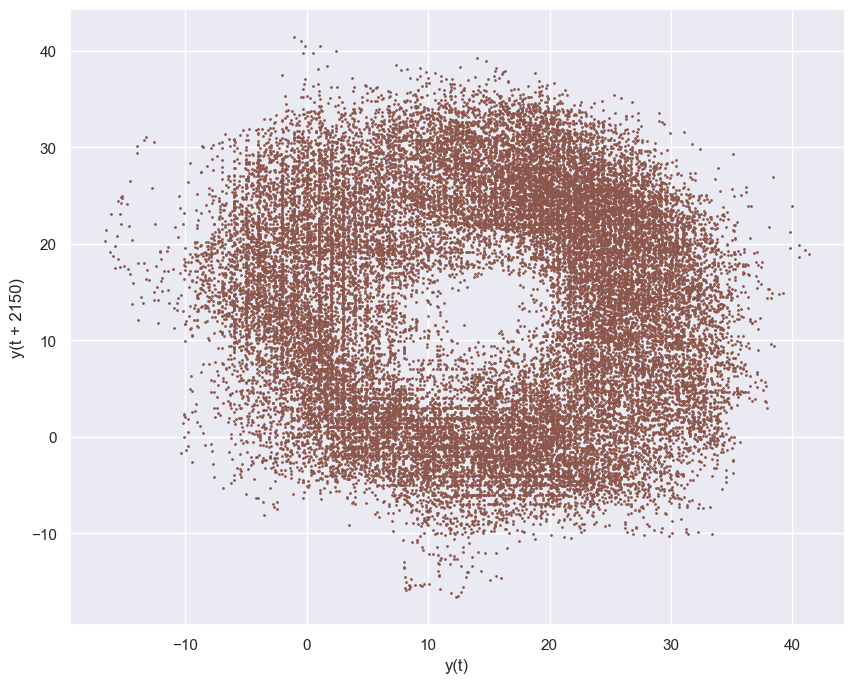

In [79]:
pd.plotting.lag_plot(df['TEMP'], lag=2150,s=1, c=[colors[5]]);

For a three-month lag, the plot shows no significant pattern, indicated by the lack of correlation between y(t) and y(t+2150).

Next, we will delve into exploring the correlations between particulate matter and other features.

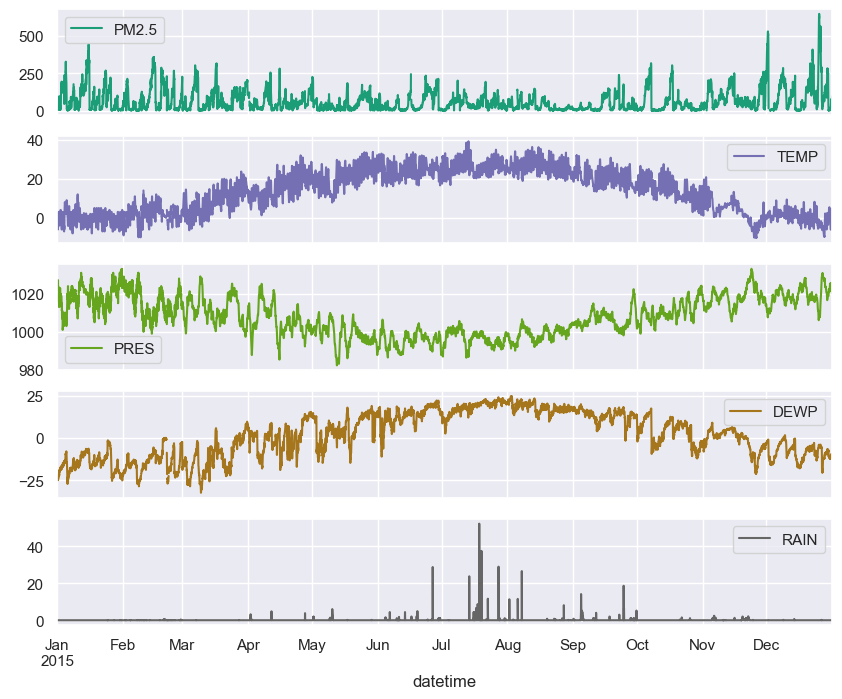

In [81]:
#plot PM2.5, TEMP, PRES, DEWP and Rain for year 2015
pm_data_2015 = df[df['year']==2015][['PM2.5', 'TEMP', 'PRES','DEWP', 'RAIN']]
pm_data_2015.plot(subplots=True, colormap=plt.cm.Dark2)
plt.show()
     

Among the different weather parameters analyzed, pressure exhibits a positive association with particulate matter levels. In contrast, temperature, dew point, and rainfall appear to have negative correlations with particulate matter concentration.

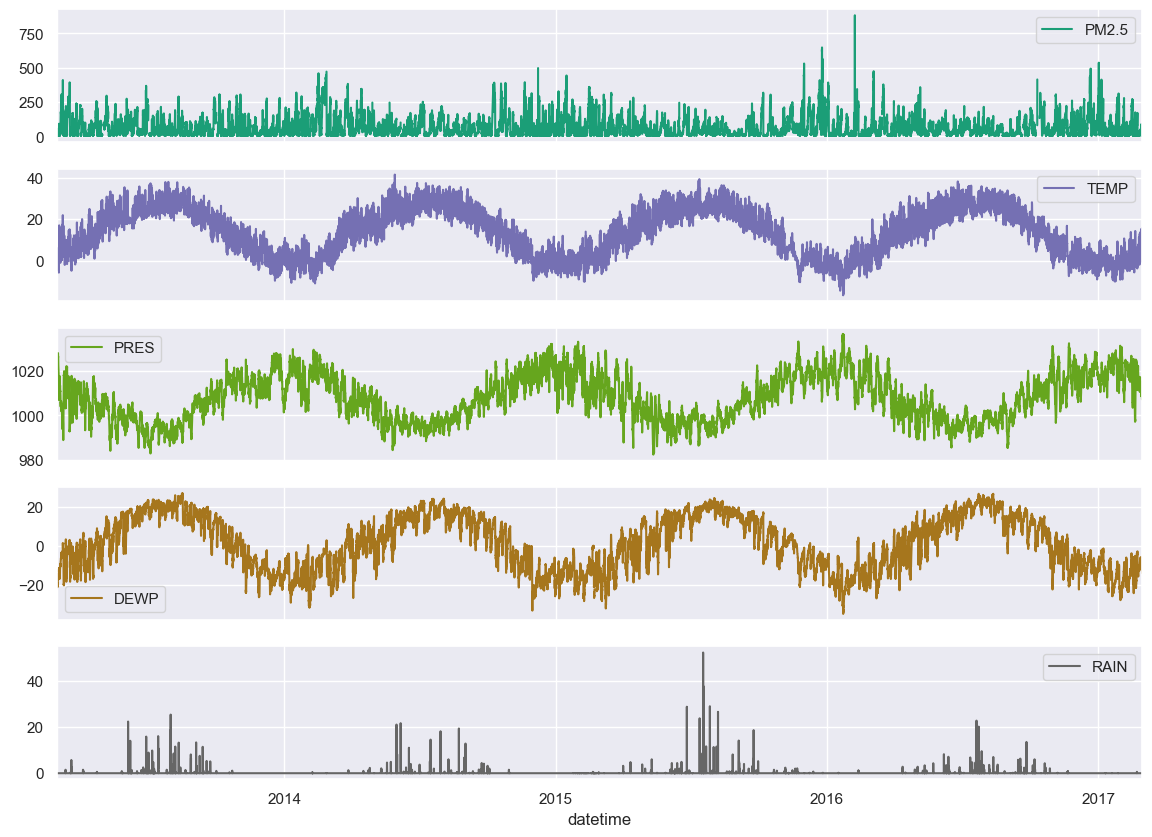

In [82]:
#plot same parameters for all years
pm_data = df[['PM2.5', 'TEMP', 'PRES', 'DEWP', 'RAIN']]
pm_data.plot(subplots=True, figsize=(14, 10), colormap=plt.cm.Dark2)
plt.show()

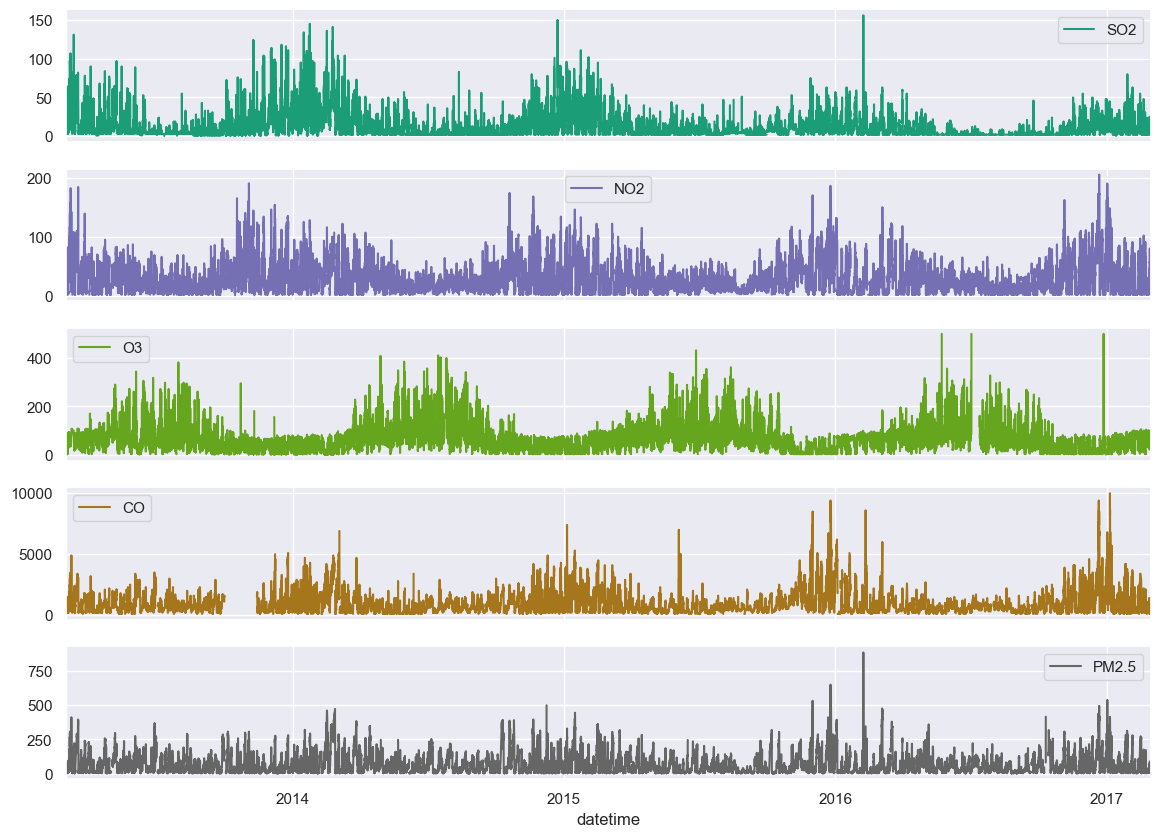

In [83]:
#plot other parameters for all years
pm_multi_data = df[['SO2', 'NO2', 'O3', 'CO', 'PM2.5']]
pm_multi_data.plot(subplots=True, colormap=plt.cm.Dark2, figsize=(14,10));

The plot indicates that a significant portion of PM2.5 is composed of fine particles, primarily carbon and nitrogen dioxide, along with a measurable amount of sulfur dioxide. This observation will be further substantiated through correlation plots, as illustrated in the subsequent figure.

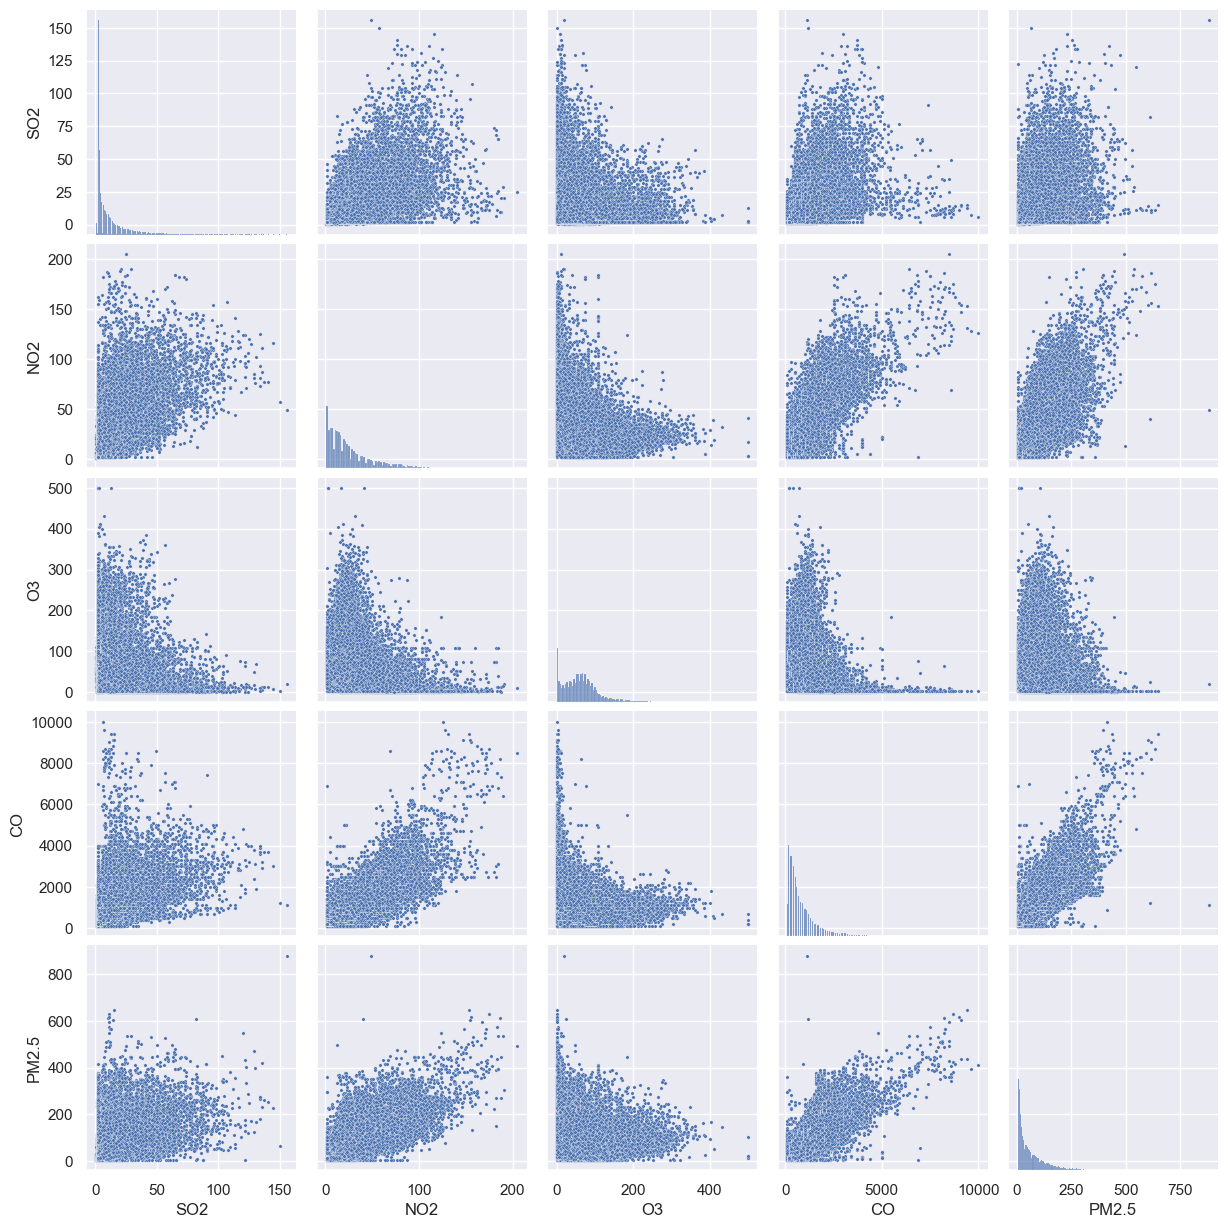

In [94]:

g = sns.pairplot(df[['SO2', 'NO2', 'O3', 'CO', 'PM2.5']],plot_kws={'s': 6});

As anticipated, there is a strong correlation observed between PM2.5 levels and both NO2 and CO concentrations.

In [95]:
aq_corr = df[['SO2', 'NO2', 'O3', 'CO', 'PM2.5']].corr(method='pearson')
aq_corr

SO2       NO2        O3        CO     PM2.5
SO2    1.000000  0.610433 -0.182096  0.529182  0.475117
NO2    0.610433  1.000000 -0.373625  0.798753  0.718170
O3    -0.182096 -0.373625  1.000000 -0.303275 -0.100542
CO     0.529182  0.798753 -0.303275  1.000000  0.802737
PM2.5  0.475117  0.718170 -0.100542  0.802737  1.000000

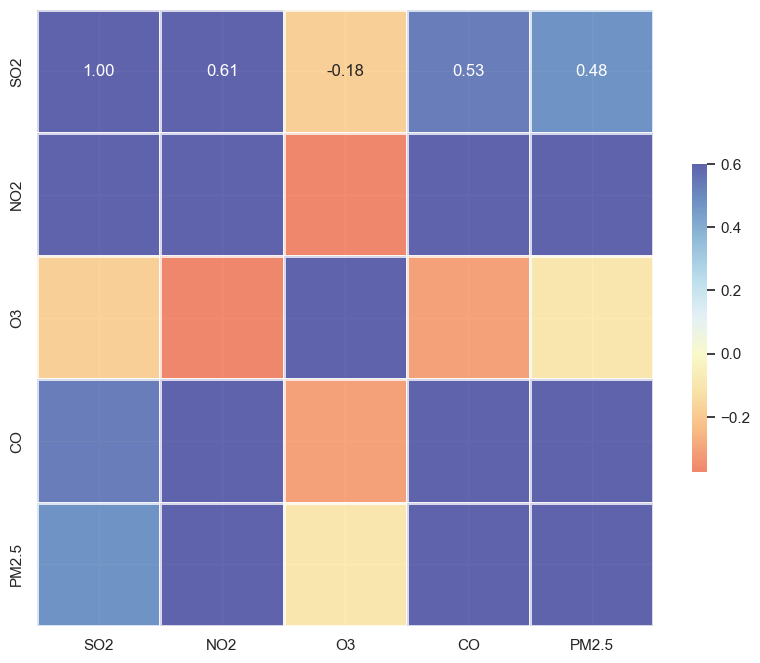

In [96]:
g = sns.heatmap(aq_corr, vmax=0.6, center=0, square=True, linewidths=1.0, alpha=0.75,
                cbar_kws={'shrink':.5}, annot=True, fmt='.2f', cmap='RdYlBu')
plt.show()

In [97]:
wd_pm25 = df.groupby('wd').agg(median=('PM2.5', 'median'), 
                     mean=('PM2.5', 'mean'), 
                     max=('PM2.5', 'max'), 
                     min=('PM2.5', 'min')).reset_index()
wd_pm25

wd  median       mean    max  min
0     E    70.0  88.623363  434.0  3.0
1   ENE    56.5  77.685514  647.0  3.0
2   ESE    78.5  96.492276  632.0  3.0
3     N    29.0  57.546221  536.0  3.0
4    NE    32.0  57.390083  530.0  3.0
5   NNE    26.0  53.946239  881.0  3.0
6   NNW    33.0  62.790775  548.0  3.0
7    NW    21.0  52.769116  535.0  3.0
8     S    52.0  72.497281  511.0  3.0
9    SE    70.0  85.045709  617.0  3.0
10  SSE    61.0  79.925967  614.0  3.0
11  SSW    50.0  73.078253  493.0  3.0
12   SW    46.0  70.233140  459.0  3.0
13    W    22.0  49.488104  446.0  3.0
14  WNW    14.0  37.307447  515.0  3.0
15  WSW    39.0  66.725926  451.0  3.0

In [98]:
df_na = df.copy()
df_na = df_na.dropna()

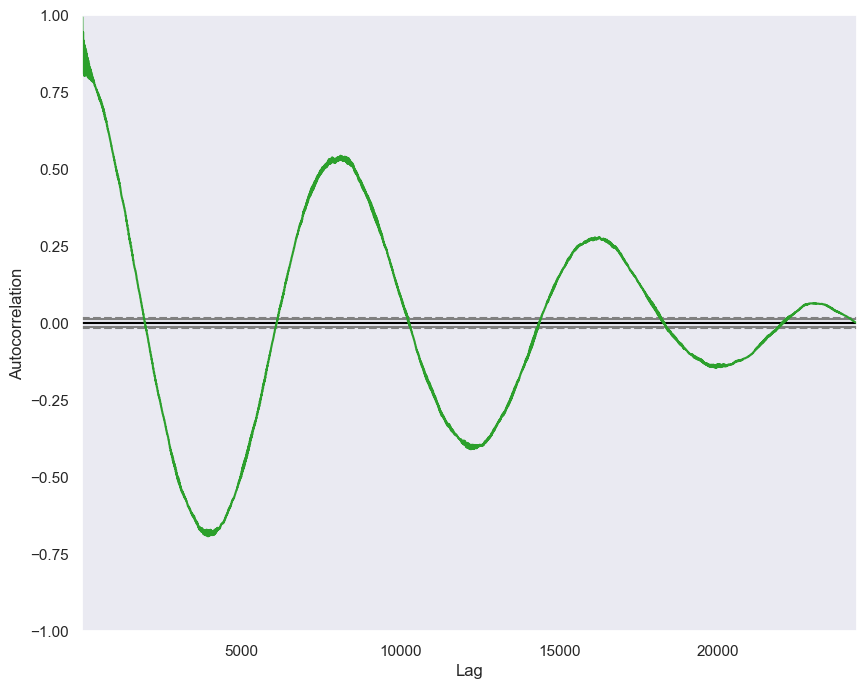

In [99]:

pd.plotting.autocorrelation_plot(df_na['2014':'2016']['TEMP'], color=colors[2]);

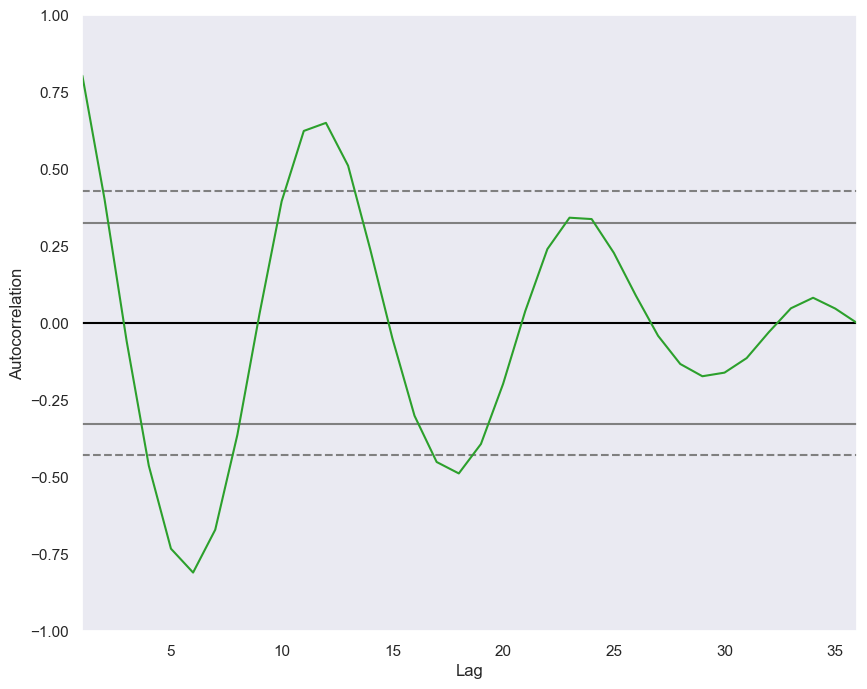

In [101]:
pd.plotting.autocorrelation_plot(df_na['2014':'2016']['TEMP'].resample('1m').mean(), color=colors[2]);

The autocorrelation plot shown illustrates the degree of similarity between the monthly average temperatures (resampled monthly) from 2014 to 2016 and their time-lagged values. The lag, represented on the x-axis in units of months, shows how past values of temperature are correlated with future values

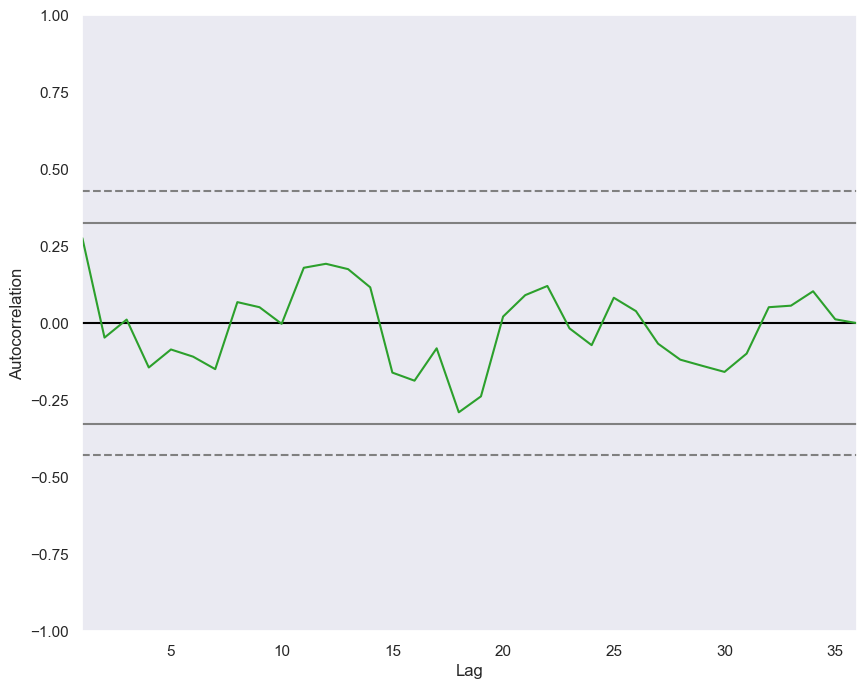

In [102]:
pd.plotting.autocorrelation_plot(df_na['2014':'2016']['PM2.5'].resample('1m').mean(), color=colors[2]);


The autocorrelation plot for the monthly mean PM2.5 values from 2014 to 2016 indicates that there is some cyclical pattern, as suggested by the fluctuations above and below the zero line. However, the correlation does not exhibit strong regular peaks, which might have suggested a more pronounced seasonal effect. This could imply that while there are periods where PM2.5 levels are somewhat predictably higher or lower, these patterns are not as strongly defined or consistent as they are with temperature, likely due to the influence of various other environmental and human factors on particulate matter concentrations